In [2]:
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.style.use('dark_background')

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

%matplotlib inline

import tensorflow as tf

In [3]:
def lorenz_dynamics(q):
    x, y, z = q[0], q[1], q[2]
    
    sigma = 10
    beta = 8/3
    rho = 28
    
    f_rhs = np.array([sigma * (y-x),
                      x * (rho - z) - y,
                      x * y - beta * z])
    
    jacobian = np.array([[-sigma, sigma, 0],
                         [rho, 1.0, -x],
                         [y, x, -beta]])
    
    return f_rhs, jacobian

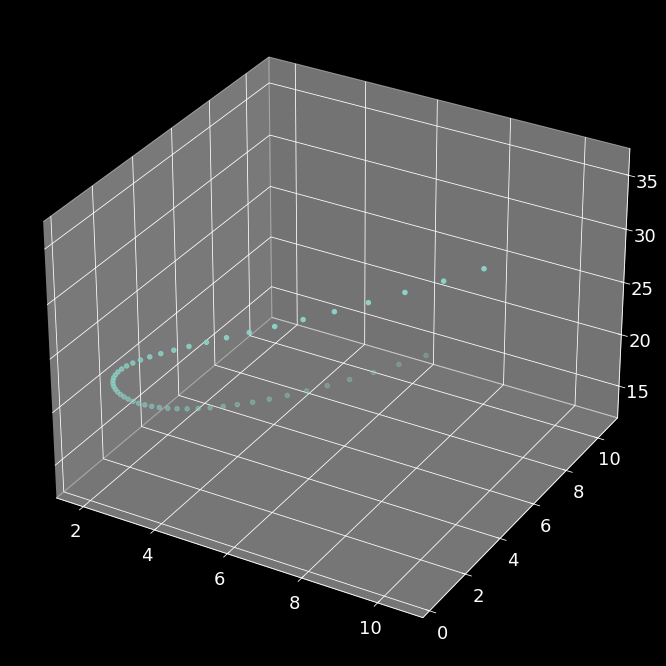

In [27]:
def irk_update(q, dt, threshold, max_iterations):
    # Use an explicit Euler step as initial guess
    rhs, jacobian = lorenz_dynamics(q)
    # position guesses
    q1 = q + 0.5 * (1.0 - 1.0/np.sqrt(3.0)) * dt * rhs
    q2 = q + 0.5 * (1.0 + 1.0/np.sqrt(3.0)) * dt * rhs
    
    # IRK matrix
    a11, a12 = 0.25, 0.25 - np.sqrt(3.0)/6.0
    a21, a22 = 0.25 + np.sqrt(3.0)/6.0, 0.25
    
    # Iterate of stages
    k1, j1 = lorenz_dynamics(q1)
    k2, j2 = lorenz_dynamics(q2)
    # print(k1.shape)
    
    def err(k1, k2):
        # print(k1.shape)
        rhs1, _ = lorenz_dynamics(q + dt * (a11 * k1 + a12 * k2))
        rhs2, _ = lorenz_dynamics(q + dt * (a21 * k1 + a22 * k2))
        error1 = k1 - rhs1
        error2 = k2 - rhs2
        return np.array([error1, error2])
    
    def err_norm(err):
        return np.sqrt(np.square(err).sum())
    
    itr = 0
    error = err_norm(err(k1, k2))
    while error > threshold and itr < max_iterations:
        # Iterate of stages
        _, j1 = lorenz_dynamics(q + dt * (a11 * k1 + a12 * k2))
        _, j2 = lorenz_dynamics(q + dt * (a21 * k1 + a22 * k2))
        
        # Jacobian of IRK method, I - dt * A * J with J jacobian of original system
        jac = np.array([[np.eye(q.shape[0]) - dt * a11 * j1, -dt * a12 * j1],
                         [-dt * a21 * j2, np.eye(q.shape[0]) - dt * a22 * j2]])
        
        # Newton iteration
        # Reshape to a single square system
        err_m = err(k1, k2)
        jac = np.transpose(jac, axes=[0, 2, 1, 3])
        jac_r = jac.reshape(2 * q.shape[0], 2 * q.shape[0])
        err_r = err_m.reshape(2 * q.shape[0])
        # k_next = np.array([k1, k2]) - linalg.solve(jac, err(k1, k2)[None, :, :])
        # solve = linalg.solve(jac, err(k1, k2)[None, :, None, :])
        solution = linalg.solve(jac_r, err_r).reshape(2, q.shape[0])
        
        # Get iterate k's
        k1 = k1 - solution[0, :]
        k2 = k2 - solution[1, :]
        
        # Error
        error = err_norm(err(k1, k2))
        
        # print('\nNewton iteration ' + str(itr) + ' with err ' + str(error))
        itr += 1
        
        if itr >= max_iterations:
            return k1, k2
        
    return k1, k2
    
# Starting point
q = np.array([10.54, 4.112, 35.82])
dt = 0.01

nt = 50

qs = np.zeros((3, nt))
qs[:, 0] = q

for i in range(1,nt):
    k1, k2 = irk_update(q, dt, threshold=1.0e-7, max_iterations=100)
    q = q + 0.5 * dt * (k1 + k2)
    qs[:, i] = q

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(qs[0, :], qs[1, :], qs[2, :])
# ax.scatter(q_next[0], q_next[1], q_next[2])